In [1]:
import math
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# dataset

from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets('./data/mnist/',one_hot=True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [6]:
print('size of training.set : \t\t{}'.format(len(data.train.labels)))
print('size of test.set : \t\t{}'.format(len(data.test.labels)))
print('size of validation.set : \t{}'.format(len(data.validation.labels)))

size of training.set : 		55000
size of test.set : 		10000
size of validation.set : 	5000


In [8]:
# retrieving contents of class labels
data.test.cls = np.argmax(data.test.labels, axis=1)

In [9]:
# number of each pixels in each dimension.
img_size = 28

# flattened format in 1-D
img_size_flt = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of color channels for the images : 1 channel for grey scale.
num_channels = 1

# number of classes 
num_classes = 10

In [133]:
def plot_img(images, cls_label, cls_pred=None):
    
    fig, axes = plt.subplots(1,10, figsize=(15,15))
    fig.subplots_adjust(hspace=0.1, wspace=0.3)
    
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(img_shape),cmap='binary')
        
        if cls_pred is None:
            label = "True: {0}".format(cls_label[idx])
        else:
            label = "True: {0} \n Pred: {1}".format(cls_label[idx],cls_pred[idx])
            
        ax.set_xlabel(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

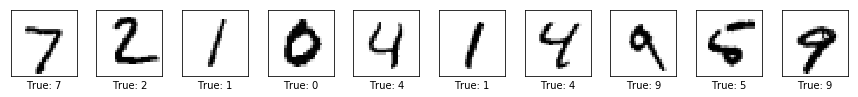

In [17]:
# getting the first ten values
images = data.test.images[0:10]

# getting the true classes
cls_true = data.test.cls[0:10]

# plot the images
plot_img(images=images, cls_label=cls_true)

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flt], name='x')

In [19]:
# in this conv-net the x is encoded to be 4dim tensor [num_images, img_height,img_width,num_channels]
# num_images can be inferred automatically by using -1 for the size of the firtss dim.

x_image = tf.reshape(x, [-1,img_size,img_size,num_channels])

In [20]:
# this variable represents the true labels associated with the images that were input in the place holder x
# this is a 2dim tensor.

y_true = tf.placeholder(tf.float32,shape=[None,num_classes], name='y_true')

In [21]:
# retrieving the data using argmax as it is one-hot encoded.
y_true_cls = tf.argmax(y_true,axis=1)

In [34]:
# convnet layer 1
filter_size1 = 5
num_filters1 = 16

# convnet layer 2
filter_size2 = 5
num_filters2 = 36

#fully connected layer
fc_size = 128


In [35]:
# generating weights and biases for thr convnet

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [36]:
# creating the conv-net
def conv_layer(input,            #the previous layer
              num_input_channels,#num of channels in previous layer
              filter_size,       #width and height of each layer
              num_filters,       #number of filters
              ):
    
    #shape of the filter and weights for the conv-net
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    #create new weight filters with the given shape
    weights = new_weights(shape=shape)
    
    #create biases, one for each filter
    biases = new_biases(length=num_filters)
    
    # creating the layer.
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1,1,1,1], # strides set to one in all dim, 
                                           # first and the last stride should always be one
                                           # first for image_number, last for input_channels.
                        padding='SAME')    # padding is set to same, meaning the input image is padded with 
                                           # zeros, so that the output image size is same.
    layer += biases
    
    # using pooling to down sample the image.
    # its a 2x2 max pooling
    layer = tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    # activation function used relu.
    layer = tf.nn.relu(layer)
    
    # Note: Relu  is normally used before pooling, but since relu(max_pool(x)) == max_pool(relu(x))
    # we can save 75% of the relu-operations by max-pooling first.
    
    return layer, weights

In [37]:
def flatten_layer(layer):
    layer_shape = layer.get_shape() # 4dim tensor
    
    # number of features : img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # reshape the layer to [num_images, num_features]
    # Note that we just set the size of the second dim
    # to num_features and the size of the first dim to -1 (all data)
    # which means the size in that dim is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # the shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    
    return layer_flat, num_features

In [38]:
def new_fc_layer(input,         #the previous layer.
                num_inputs,     #num of inputs from prev layer.
                num_outputs,    #num outputs. 
                use_relu=True): #use rectified linear unit (Relu)
    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases  = new_biases(length=num_outputs)
    
    #calculate the layer as the dot product of
    #the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer    

In [39]:
# conv-net layer 1
layer_conv1, weights_conv1 = conv_layer(input=x_image, 
                                        num_input_channels=num_channels,
                                       filter_size=filter_size1,
                                        num_filters=num_filters1,)


In [40]:
# size after convolution operation.
layer_conv1

<tf.Tensor 'Relu_2:0' shape=(?, 14, 14, 16) dtype=float32>

In [45]:
# conv-net layer 2
layer_conv2, weights_conv2 = conv_layer(input=layer_conv1, 
                                        num_input_channels=num_filters1,
                                       filter_size=filter_size2,
                                       num_filters=num_filters2,)

In [46]:
layer_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

In [47]:
# flatten layer conversion
layer_flat, num_features = flatten_layer(layer_conv2)
num_features

1764

In [48]:
# fully connected layer1.
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [49]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [50]:
# fully connected layer.
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [51]:
layer_fc2

<tf.Tensor 'add_6:0' shape=(?, 10) dtype=float32>

In [52]:
# prediction 
y_pred = tf.nn.softmax(layer_fc2)

In [54]:
# getting the class of the prediction
y_pred_cls = tf.argmax(y_pred, axis=1)

In [55]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,labels=y_true)

In [56]:
#we are taking the average of all crossentropy for all the image classification.
cost = tf.reduce_mean(cross_entropy)

In [57]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [58]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [60]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [61]:
# creating a session
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

In [62]:
train_batch_size = 64

In [65]:
total_iteration = 0

def optimize(num_iterations):
    global total_iteration
    
    for i in range(total_iteration, total_iteration + num_iterations):
        
        # get the batch of trainning examples
        # x_batch holds a batch of images
        # y_true_batch are the true labels for the images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # implementing a dictionary for the batches
        feed_dict_train = {x:x_batch, y_true:y_true_batch}
        
        # run the optimizer using batch of training data.
        # tensorflow assigns the variables in the dict to the placeholder and then will run the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = 'optimization itteration : {0:>6}, Training Accuracy: {1:>6.1%}'
            print(msg.format(i+1,acc))
        
        total_iteration += num_iterations

In [67]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class number for all images in the test set.
    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.
    
    # negate the bolean array.
    incorrect = (correct == False)
    
    #get the images from the test set that have been incorrectly classified.
    images = data.test.images[incorrect]
    
    #get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    
    #get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    plot_img(images=images[0:10],
             cls_label=cls_true[0:10],
             cls_pred=cls_pred[0:10])

In [86]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

In [79]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False):
    
    num_test = len(data.test.images)
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    
    while i < num_test:
        
        # ending index of the next batch is denoted by j.
        j = min(i + test_batch_size, num_test)
        
        # get the image from the test set between index i and  j.
        images = data.test.images[i:j,:]
        
        #get the associated labels.
        labels = data.test.labels[i:j,:]
        
        # create a feed-dict with these images and labels.
        feed_dict = {x:images,
                    y_true:labels}
        
        # calculate the predicted class using tensorflow.
        cls_pred[i:j] = session.run(y_pred_cls,feed_dict=feed_dict)
        
        # setting start index of the next batch by end index of this batch.
        i = j
    
    cls_true = data.test.cls
    
    #create a bolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
    #calculate the number of correctly classified images,
    #when suming a bolean array, false means 0 and True means 1.
    
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / num_test
    
    msg = 'Accuracy on test set: {0:.1%} ({1}/{2})'
    print(msg.format(acc,correct_sum,num_test))
    
    # Plot some examples of misclassification, if desired
    if show_example_errors:
        print('Example errors:')
        plot_example_errors(cls_pred=cls_pred,correct=correct)
    
    #plot the confusoin matrix 
    if show_confusion_matrix:
        print("Confusion Matrix :")
        plot_confusion_matrix(cls_pred=cls_pred)

In [73]:
print_test_accuracy()

Accuracy on test set: 9.9% (986/10000)


In [74]:
optimize(num_iterations=10)

optimization itteration :      1, Training Accuracy:   7.8%


In [75]:
print_test_accuracy()

Accuracy on test set: 9.8% (980/10000)


In [76]:
optimize(num_iterations=990)

optimization itteration :    101, Training Accuracy:  12.5%
optimization itteration :    201, Training Accuracy:  67.2%
optimization itteration :    301, Training Accuracy:  76.6%
optimization itteration :    401, Training Accuracy:  84.4%
optimization itteration :    501, Training Accuracy:  85.9%
optimization itteration :    601, Training Accuracy:  82.8%
optimization itteration :    701, Training Accuracy:  90.6%
optimization itteration :    801, Training Accuracy:  90.6%
optimization itteration :    901, Training Accuracy:  90.6%
optimization itteration :   1001, Training Accuracy:  90.6%


Accuracy on test set: 92.9% (9294/10000)
Example errors:


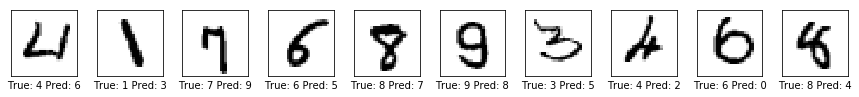

In [80]:
print_test_accuracy(show_example_errors=True)

In [82]:
optimize(num_iterations=9000)

optimization itteration : 3464201, Training Accuracy:  95.3%
optimization itteration : 3464301, Training Accuracy:  95.3%
optimization itteration : 3464401, Training Accuracy:  96.9%
optimization itteration : 3464501, Training Accuracy:  96.9%
optimization itteration : 3464601, Training Accuracy:  93.8%
optimization itteration : 3464701, Training Accuracy:  93.8%
optimization itteration : 3464801, Training Accuracy:  98.4%
optimization itteration : 3464901, Training Accuracy:  95.3%
optimization itteration : 3465001, Training Accuracy:  96.9%
optimization itteration : 3465101, Training Accuracy:  95.3%
optimization itteration : 3465201, Training Accuracy:  98.4%
optimization itteration : 3465301, Training Accuracy:  98.4%
optimization itteration : 3465401, Training Accuracy:  98.4%
optimization itteration : 3465501, Training Accuracy:  92.2%
optimization itteration : 3465601, Training Accuracy:  96.9%
optimization itteration : 3465701, Training Accuracy:  95.3%
optimization itteration 

Accuracy on test set: 98.5% (9850/10000)
Example errors:


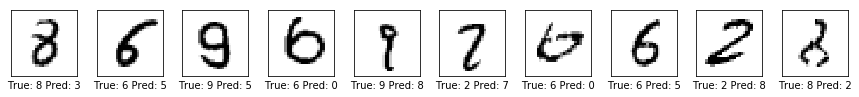

Confusion Matrix :
[[ 974    0    0    0    0    1    1    1    3    0]
 [   0 1130    0    0    0    1    1    0    3    0]
 [   2    2 1011    3    1    0    0    4    9    0]
 [   0    0    0 1002    0    5    0    2    1    0]
 [   0    0    0    0  971    0    0    3    2    6]
 [   1    0    0    1    0  889    1    0    0    0]
 [   9    3    0    1    3   16  925    0    1    0]
 [   1    2    4    3    1    1    0 1010    3    3]
 [   3    0    2    5    0    3    0    2  957    2]
 [   3    3    0    4    4    7    0    3    4  981]]


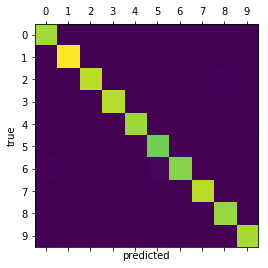

In [87]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [88]:
def plot_conv_weights(weights, input_channel= 0):
    # retrieve the values of the weight variables from tensorflow
    # A feed dict is not necessary because nothing is calculated.
    w = session.run(weights)
    
    # get the min and max values of weights, so as to correct the color intensity for comparison.
    w_min = np.min(w)
    w_max = np.max(w)
    
    num_filters = w.shape[3] #nummber of filters in the conv layer
    
    # Number of grids to plot.
    # Rounded-up square-root of the number of filtrs.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # create fig with grid of subplot
    fig, axes = plt.subplots(num_grids,num_grids)
    
    for i, ax in enumerate(axes.flat):
        # plot the filter weights.
        if i < num_filters:
            # get the ith filter of the input channel.
            img = w[:,:,input_channel,i]
            ax.imshow(img,vmin=w_min,vmax=w_max,interpolation='nearest',cmap='seismic')
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [101]:
def plot_conv_layer(layer, image):
    
    # create a dict with just image as we don't need y_true here.
    feed_dict = {x:images}
    
    # retrieve the output values of the layer.
    values = session.run(layer, feed_dict=feed_dict)
    
    # number of filter used in the conv lyer.
    num_filters = values.shape[3]
    
    # Number of grids to plot.
    # Rounded-up square-root of the number of filtrs.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # create fig with grid of subplot
    fig, axes = plt.subplots(num_grids,num_grids)
    
    for i, ax in enumerate(axes.flat):
        # plot the filter weights.
        if i < num_filters:
            # get the ith filter of the input channel.
            img = values[0,:,:,i]
            ax.imshow(img,interpolation='nearest',cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

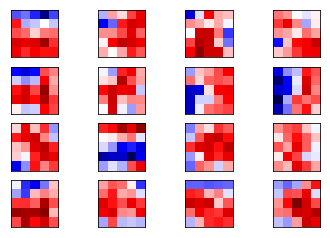

In [102]:
# conv-net layer1 weights
plot_conv_weights(weights=weights_conv1)

In [103]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
              interpolation='nearest',cmap='binary')
    plt.show()

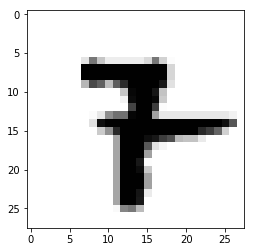

In [104]:
image1 = data.test.images[97]
plot_image(image1)

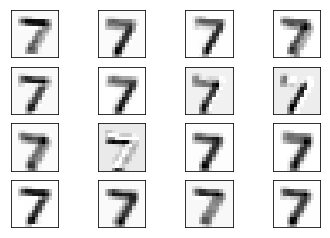

In [105]:
# conv-net layer 1
plot_conv_layer(layer=layer_conv1, image=image1)

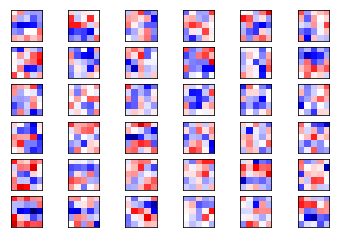

In [106]:
# conv-net layer2 weights
plot_conv_weights(weights=weights_conv2)

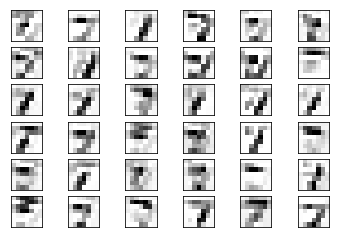

In [107]:
# conv-net layer 2
plot_conv_layer(layer=layer_conv2, image=image1)

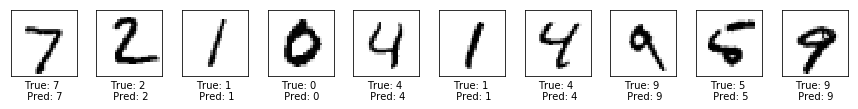

In [135]:
# getting the first ten values
images = data.test.images[0:10]

# getting the true classes
cls_true = data.test.cls[0:10]

# getting the predicted classes)
labels = data.test.labels[0:10]
prediction = session.run(y_pred_cls,feed_dict = {x:images,y_true:labels})
# plot the images
plot_img(images=images, cls_label=cls_true, cls_pred=prediction)